In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random
import re
import string
from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer        
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/vuhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
tweets = df[['id', 'text', 'target']]
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


In [4]:
tweets.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
tweets['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

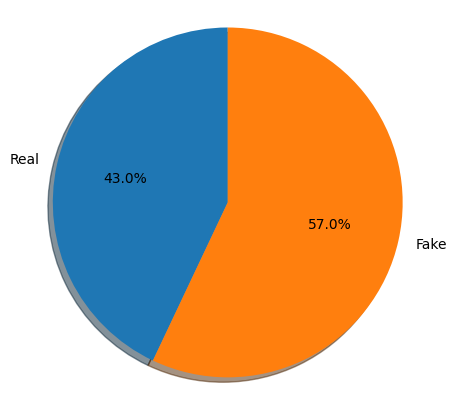

In [6]:
fig = plt.figure(figsize=(5, 5))

labels = 'Real', 'Fake'

sizes = [len(tweets.loc[tweets['target'] == 1]), len(tweets.loc[tweets['target'] == 0])]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

# Preprocessing

Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:

* Tokenizing the string
* Lowercasing
* Removing stop words and punctuation
* Stemming


## `process_tweet()`

In [7]:
def process_tweets(tweet, stem=True):
    
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    
    stopwords_eng = stopwords.words('english')
    tweet_clean = []
    for word in tweet_tokens:
        if word not in stopwords_eng and word not in string.punctuation:
            tweet_clean.append(word)
    if stem==False:
        return tweet_clean
    else:    
        tweet_stem = []
        stemmer = PorterStemmer()
        for word in tweet_clean:
            stem_word = stemmer.stem(word)
            tweet_stem.append(stem_word)
        return tweet_stem

In [8]:
org_tweet = tweets.iloc[0, 1]
print('Tweet: {}'.format(org_tweet))
print()
token_tweet = process_tweets(org_tweet)
print('Tokenized Tweet: {}'.format(token_tweet))

Tweet: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Tokenized Tweet: ['deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'us']


In [9]:
np.squeeze(tweets['target'].values)

array([1, 1, 1, ..., 1, 1, 1])

## Word frequency dictionary

In [10]:
def build_freqs(label, tweets):
    y_list = np.squeeze(label).tolist()
    
    freqs = {}
    
    for y, tweet in zip(y_list, tweets):
        for word in process_tweets(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [11]:
text = tweets['text']
label = tweets['target']

freqs = build_freqs(label, text)

In [12]:
len(freqs)

15929

## Table of word counts

In [13]:
def word_count_table(sample):
    keys = process_tweets(sample)
    
    data = []
    for word in keys:
        real = 0
        fake = 0
        
        if (word, 1) in freqs:
            real = freqs.get((word, 1), 0)
        if (word, 0) in freqs:
            fake = freqs.get((word, 0), 0)
        data.append([word, real, fake])
    return data

In [14]:
word_count_table(text[0])

[['deed', 1, 1],
 ['reason', 8, 23],
 ['earthquak', 47, 6],
 ['may', 50, 38],
 ['allah', 6, 3],
 ['forgiv', 1, 2],
 ['us', 49, 75]]

In [15]:
demo = 'happi merri nice good bad sad mad best pretti ❤ :) :( 😒 😬 😄 😍 ♛ song idea power play magnific'
demo1 = text[0]
tmp = word_count_table(demo1)
tmp

[['deed', 1, 1],
 ['reason', 8, 23],
 ['earthquak', 47, 6],
 ['may', 50, 38],
 ['allah', 6, 3],
 ['forgiv', 1, 2],
 ['us', 49, 75]]

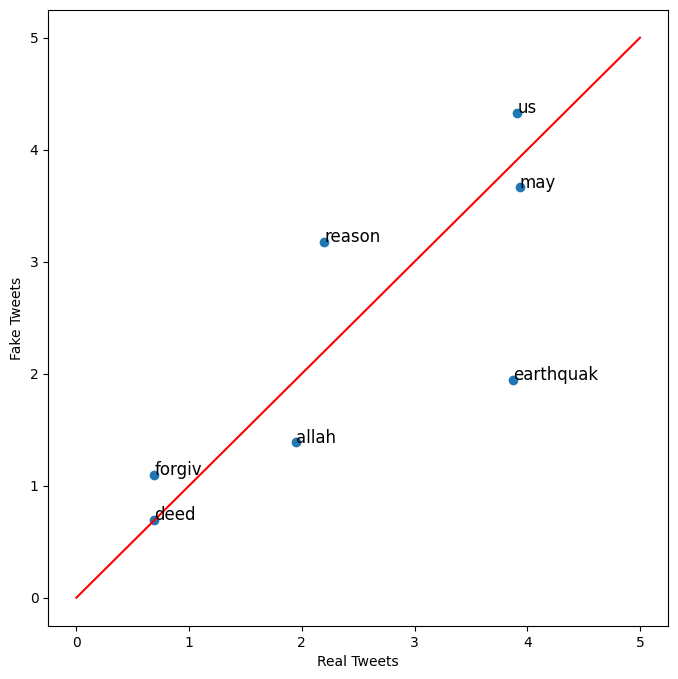

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

x = np.log([x[1] + 1 for x in tmp])
y = np.log([x[2] + 1 for x in tmp])

ax.scatter(x, y)

plt.xlabel('Real Tweets')
plt.ylabel('Fake Tweets')

ax.plot([0, 5], [0, 5], color='r')

for i in range(0, len(tmp)):
    ax.annotate(tmp[i][0], (x[i], y[i]), fontsize=12);

In [17]:
data = pd.DataFrame(tmp, columns=['word', 'pos', 'neg'])
data['bias'] = [1] * len(data)
data

,word,pos,neg,bias
0,deed,1,1,1
1,reason,8,23,1
2,earthquak,47,6,1
3,may,50,38,1
4,allah,6,3,1
5,forgiv,1,2,1
6,us,49,75,1


In [18]:
np.zeros(3)

array([0., 0., 0.])

# Building and training Logistic Regression model

## Extracting features

* Given a list of tweets, extract the features and store them in a matrix. You will extract two features.
    * The first feature is the number of real words in a tweet.
    * The second feature is the number of fake words in a tweet. 
* Then train your logistic regression classifier on these features.
* Test the classifier on a validation set. 

In [19]:
def extract_features(tweet):
    word_l = process_tweets(tweet)
    x = np.zeros(3)
    x[0] = 1
    for word in word_l:
        x[1] += freqs.get((word, 1), 0)
        x[2] += freqs.get((word, 0), 0)
        
    x = x[np.newaxis, :]
    return x

In [20]:
tmp1 = extract_features(demo1)
tmp1

array([[  1., 162., 148.]])

In [21]:
X_train = np.zeros((len(tweets), 3))

for i in range(len(text)):
    X_train[i, :] = extract_features(text[i])

In [22]:
X_train

array([[  1., 162., 148.],
       [  1., 402., 120.],
       [  1., 253., 125.],
       ...,
       [  1.,  83.,   9.],
       [  1., 358., 226.],
       [  1., 599., 120.]])

In [23]:
y_train = label.values.reshape(len(X_train), 1)
y_train

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

## Sigmoid Function

* The sigmoid function is defined as: 

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 


In [24]:
def sigmoid(z):
    h = 1 / (1 + np.exp(-z))
    return h

<a name='ex-2'></a>
## Gradient Descent
Implement gradient descent function.
* The number of iterations 'num_iters" is the number of times that you'll use the entire training set.
* For each iteration, you'll calculate the cost function using all training examples (there are 'm' training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1) 
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

In [25]:
def gradient_descent(x, y, theta, alpha, num_iter):
    m = x.shape[0]
    for i in range(0, num_iter):
        z = np.dot(x, theta)
        h = sigmoid(z)
        J = (-1 / m) * (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h)))
        theta = theta - (alpha / m) * np.dot(x.T, (h-y))
    J = float(J)
    return J, theta

## Training Model

In [26]:
J, theta = gradient_descent(X_train, y_train, np.zeros((3, 1)), 1e-6, 2000)

In [27]:
J

0.5195146728131057

In [28]:
theta

array([[-7.38012971e-05],
       [ 7.82400686e-03],
       [-8.43251467e-03]])

## Predicting

Predict whether a tweet is real or fake.

* Given a tweet, process it, then extract the features.
* Apply the model's learned weights on the features to get the logits.
* Apply the sigmoid to the logits to get the prediction (a value between 0 and 1).

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [29]:
def predicting_tweet(tweet, theta):
    x = extract_features(tweet)
    
    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred

In [30]:
tmp_res = predicting_tweet(text[0], theta)
tmp_res

array([[0.50485063]])

In [31]:
for tweet in ['I am happy', 
              'I am bad', 
              'this movie should have been great.', 
              'great', 'great great', 
              'great great great', 
              'great great great great']:
    print( '%s -> %f' % (tweet, predicting_tweet(tweet, theta)))    

I am happy -> 0.457466
I am bad -> 0.445969
this movie should have been great. -> 0.397213
great -> 0.430689
great great -> 0.364008
great great great -> 0.302172
great great great great -> 0.246764


In [32]:
for s, t in zip(text[: 10], label[:10]):
    print('Label: {} -> Predicted: {}'.format(t, predicting_tweet(s, theta)[0][0]))

Label: 1 -> Predicted: 0.5048506326150362
Label: 1 -> Predicted: 0.8940955329387259
Label: 1 -> Predicted: 0.7161280225805002
Label: 1 -> Predicted: 0.8949322868833166
Label: 1 -> Predicted: 0.43677486185046127
Label: 1 -> Predicted: 0.971038199091047
Label: 1 -> Predicted: 0.935705631664727
Label: 1 -> Predicted: 0.66890564853621
Label: 1 -> Predicted: 0.7025805777709577
Label: 1 -> Predicted: 0.5171271713837903


## Testing

* Given the test data and the weights of your trained model, calculate the accuracy of your logistic regression model. 
* Use your 'predicting_tweet' function to make predictions on each tweet in the test set.
* If the prediction is > 0.5, set the model's classification 'y_hat' to 1, otherwise set the model's classification 'y_hat' to 0.
* A prediction is accurate when the y_hat equals the test_y.  Sum up all the instances when they are equal and divide by m.

In [33]:
def testing_logistic_regression(X, y, theta):
    yhat = []
    for tweet in X:
        y_pred = predicting_tweet(tweet, theta)
        if y_pred >= 0.5:
            yhat.append(1)
        else:
            yhat.append(0)
    accuracy = np.sum(np.asarray(yhat) == np.squeeze(y)) / len(y)
    return accuracy

In [34]:
tmp_acc = testing_logistic_regression(text, y_train, theta)
tmp_acc

0.7748587941678707

## Visualizing tweets and the Logistic Regression model

In [35]:
visual = pd.DataFrame(X_train, columns = ['bias', 'real', 'fakes'])
visual['sentiment'] = label.values

visual

,bias,real,fakes,sentiment
0,1.0,162.0,148.0,1
1,1.0,402.0,120.0,1
2,1.0,253.0,125.0,1
3,1.0,429.0,144.0,1
4,1.0,196.0,212.0,1
...,...,...,...,...
7608,1.0,338.0,151.0,1
7609,1.0,592.0,252.0,1
7610,1.0,83.0,9.0,1
7611,1.0,358.0,226.0,1


In [36]:
theta = np.squeeze(theta) 
theta

array([-7.38012971e-05,  7.82400686e-03, -8.43251467e-03])

In [37]:
X = visual[visual.columns[: -1]].values
Y = visual['sentiment'].values

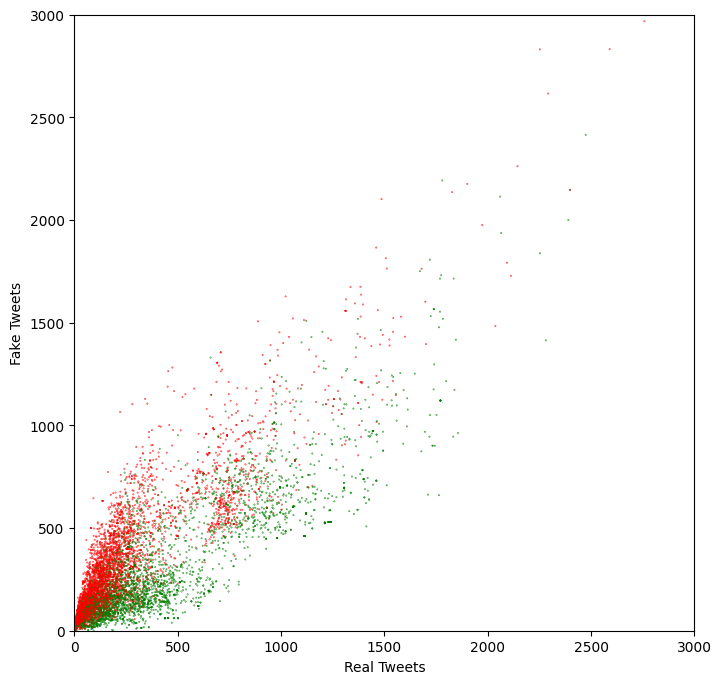

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))

colors = ['red', 'green']
ax.scatter(X[:, 1], X[:, 2], c=[colors[int(k)] for k in Y], s = 0.1)
plt.xlim([0, 3000])
plt.ylim([0, 3000])
plt.xlabel('Real Tweets')
plt.ylabel('Fake Tweets')
plt.show()

From the plot, it is evident that the features that we have chosen to represent tweets as numerical vectors show an overlapping between real and fake tweets. So we shouldn't expect a very high accuracy for this model! 

## Plot the model alongside the data

We will draw a gray line to show the cutoff between the positive and negative regions. In other words, the gray line marks the line where $$ z = \theta * x = 0.$$
To draw this line, we have to solve the above equation in terms of one of the independent variables.

$$ z = \theta * x = 0$$
$$ x = [1, pos, neg] $$
$$ z(\theta, x) = \theta_0+ \theta_1 * pos + \theta_2 * neg = 0 $$
$$ neg = (-\theta_0 - \theta_1 * pos) / \theta_2 $$

The red and green lines that point in the direction of the corresponding sentiment are calculated using a perpendicular line to the separation line calculated in the previous equations (neg function). It must point in the same direction as the derivative of the Logit function, but the magnitude may differ. It is only for a visual representation of the model. 

$$direction = pos * \theta_2 / \theta_1$$

In [39]:
def neg(theta, real):
    return (-theta[0] - real * theta[1]) / theta[2]

def direction(theta, real):
    return real * theta[2] / theta[1]

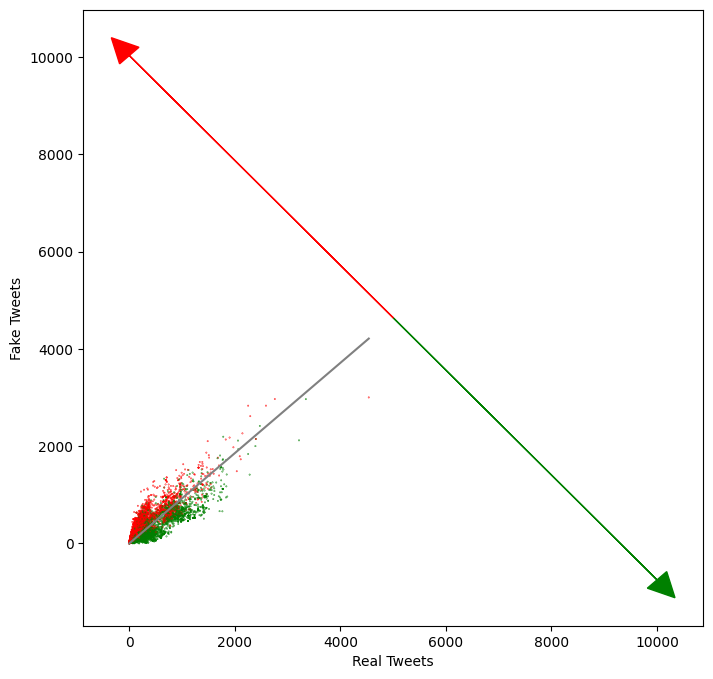

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))

colors = ['red', 'green']
ax.scatter(X[:, 1], X[:, 2], c=[colors[int(k)] for k in Y], s = 0.1)
# plt.xlim([0, 3000])
# plt.ylim([0, 3000])
plt.xlabel('Real Tweets')
plt.ylabel('Fake Tweets')

maxreal = np.max(X[:,1])

offset = 5000 # The pos value for the direction vectors origin
# Plot a gray line that divides the 2 areas.
ax.plot([0,  maxreal], [neg(theta, 0),   neg(theta, maxreal)], color = 'gray') 
# Plot a green line pointing to the real direction
ax.arrow(offset, neg(theta, offset), offset, direction(theta, offset), head_width=500, head_length=500, fc='g', ec='g')
# Plot a red line pointing to the fake direction
ax.arrow(offset, neg(theta, offset), -offset, -direction(theta, offset), head_width=500, head_length=500, fc='r', ec='r')
plt.show()